In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/skin_cancer_dataset/ISBI2016/train set/'
test_dir = '/content/drive/MyDrive/skin_cancer_dataset/ISBI2016/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

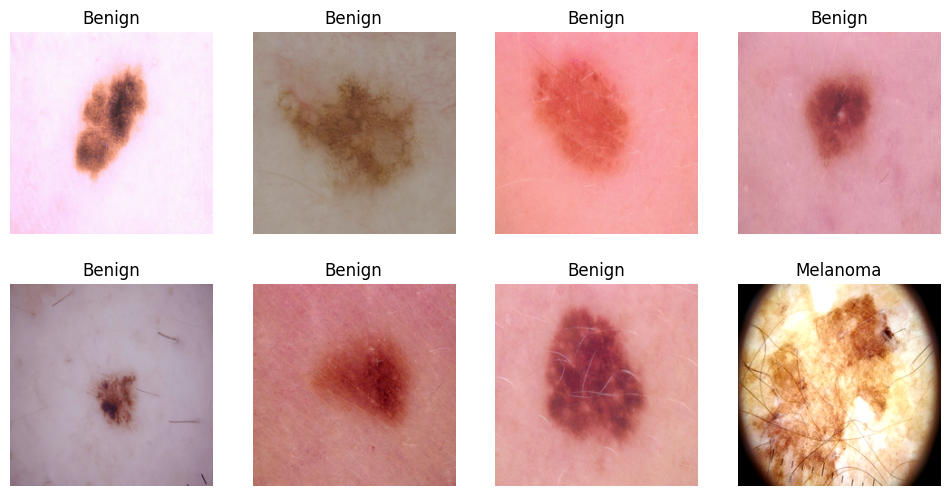

In [ ]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [ ]:

# Define the base model from VGG16
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable except the last few
for layer in base_model.layers:
    layer.trainable = False
# Set the last VGG block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Define the input layer explicitly
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add the VGG16 base model
x = base_model(input_layer)

# Add additional layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(unique_labels), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 7,145,346 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

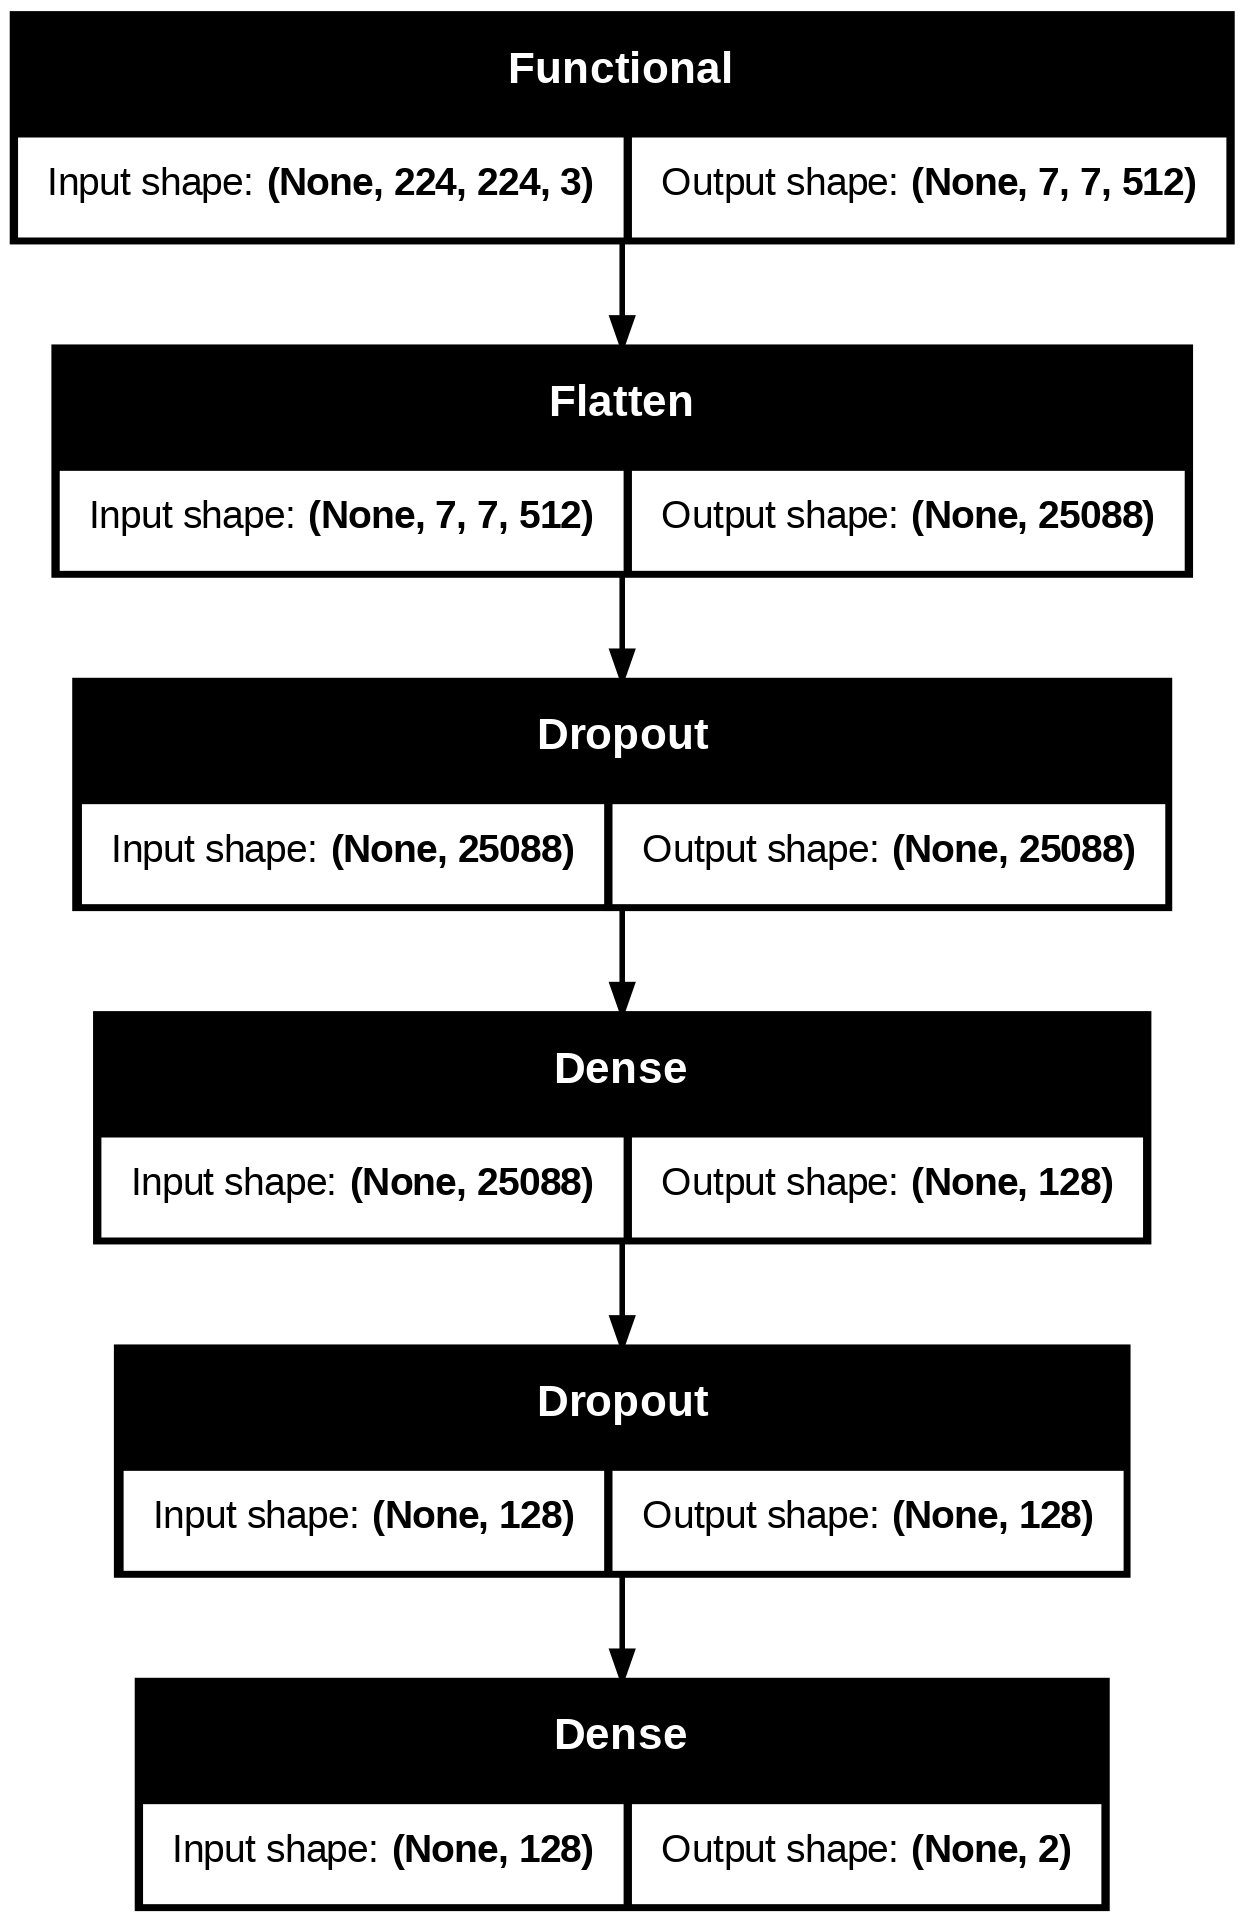

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.4729 - sparse_categorical_accuracy: 0.7688
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.1733 - sparse_categorical_accuracy: 0.9175
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9502
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - loss: 0.1141 - sparse_categorical_accuracy: 0.9531
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0682 - sparse_categorical_accuracy: 0.9810
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.0535 - sparse_categorical_accuracy: 0.9748
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9723
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9888
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.0552 - sparse_categorical_accuracy: 0.9811
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step -

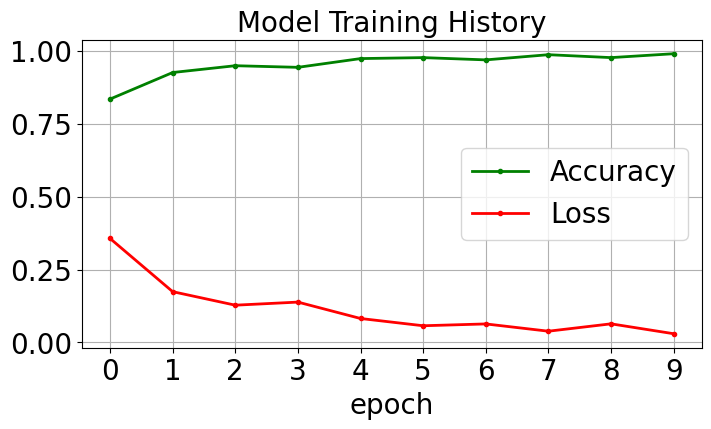

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='center right', fontsize =20)
plt.show()

# Federated Learning Based transfer Learning enabled MobileNet Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.9827
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9713
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9845
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9726
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9826
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0509 - sparse_categorical_accuracy: 0.9869
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9876
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.1602 - sparse_categorical_accuracy: 0.9578
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9992
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.014

  0%|          | 0/11 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


  9%|▉         | 1/11 [00:26<04:20, 26.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 2/11 [00:39<02:46, 18.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 3/11 [00:52<02:09, 16.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 4/11 [01:04<01:42, 14.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▌     | 5/11 [01:17<01:23, 13.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 6/11 [01:30<01:07, 13.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▎   | 7/11 [01:42<00:52, 13.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 8/11 [01:55<00:38, 12.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 9/11 [02:06<00:25, 12.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 10/11 [02:19<00:12, 12.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 11/11 [02:31<00:00, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


12it [03:02, 15.18s/it]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95       304
    Melanoma       0.91      0.67      0.77        75

    accuracy                           0.92       379
   macro avg       0.92      0.83      0.86       379
weighted avg       0.92      0.92      0.92       379



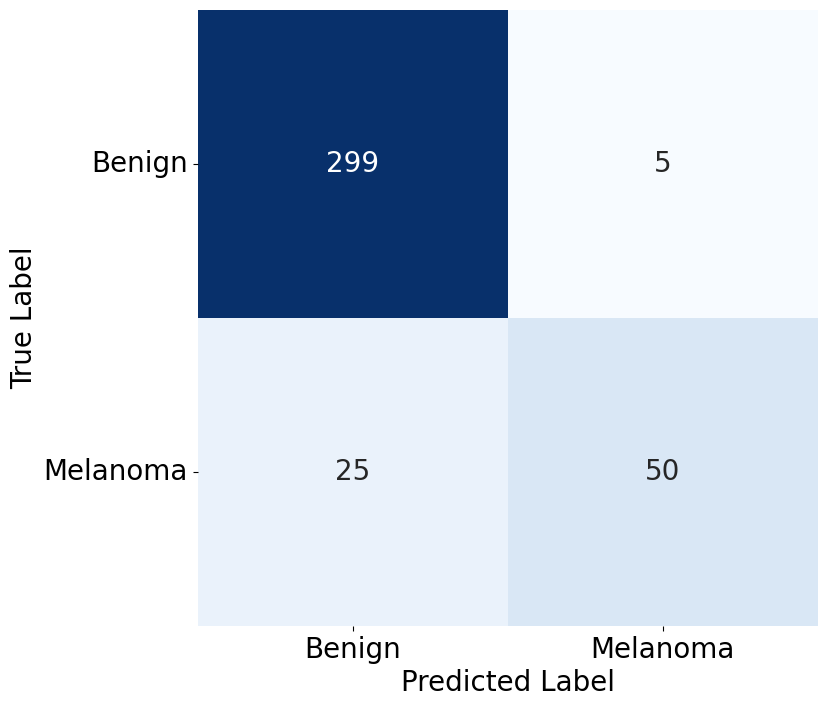

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 50.000000 TN: 299.000000 FP: 5.000000 FN: 25.000000


In [ ]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.92084
Specificity: 0.98355
 Recall: 0.66667
 Precision: 0.90909
F1 Score: 0.76923


In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
TP=50
TN=299
FP=5
FN=25
# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")

AUC: 0.82511
MCC: 0.73548
Cohen's Kappa: 0.72282


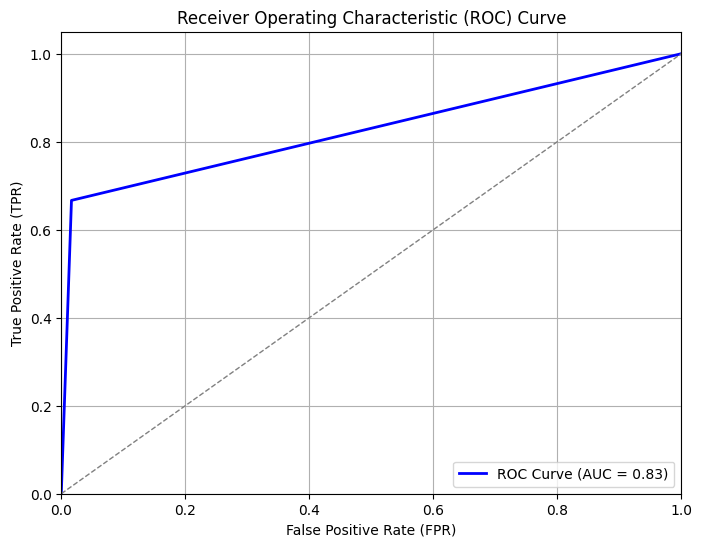

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

# Improved Code of Transfer Learning Based MobileNet Model

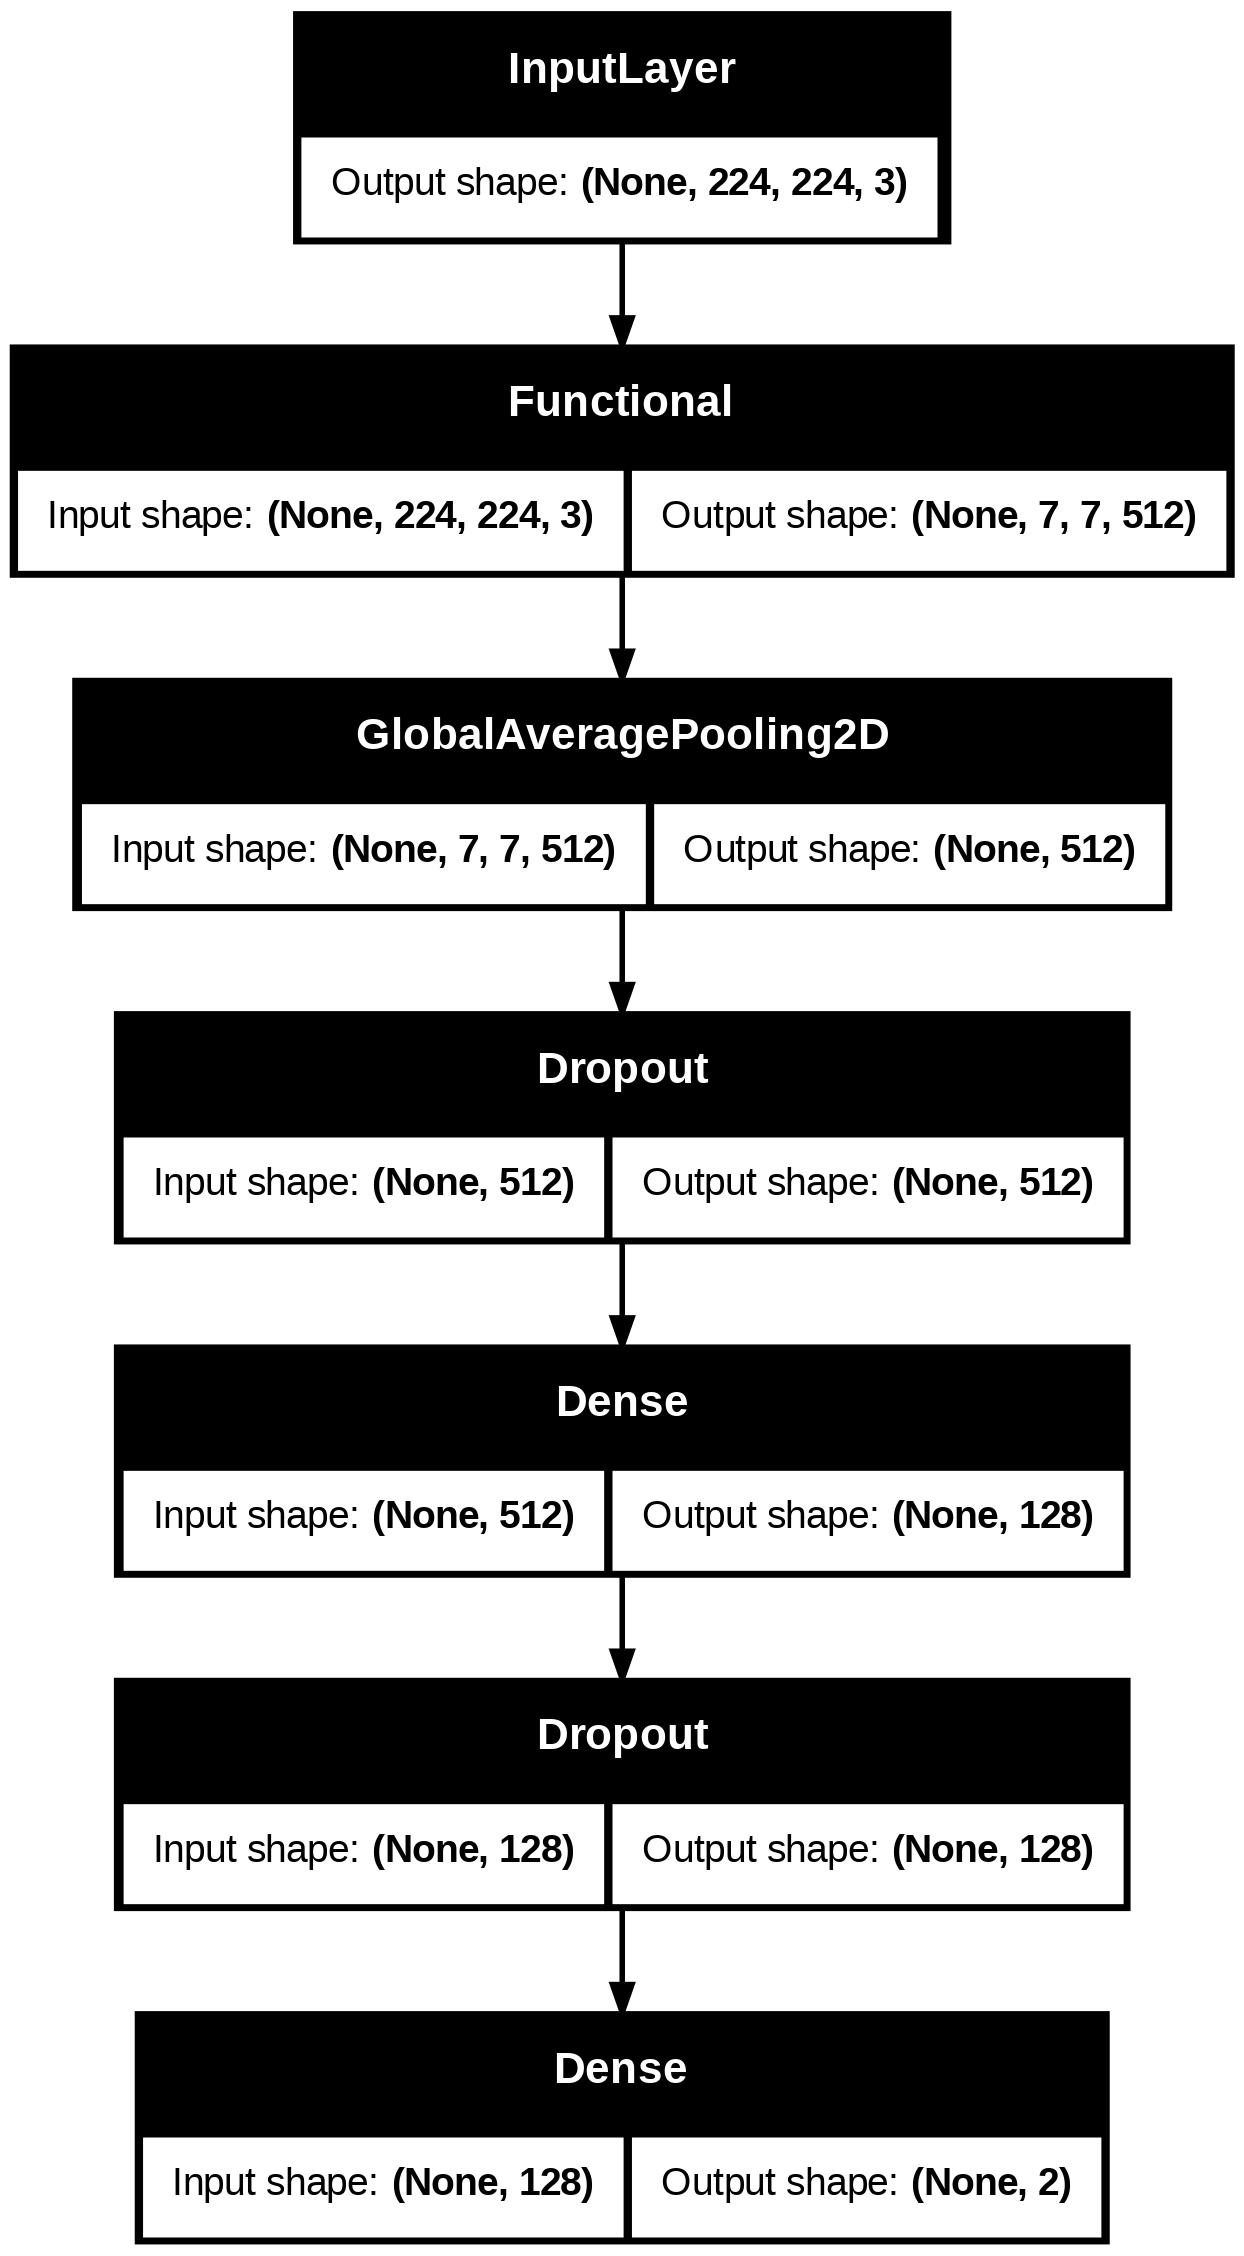

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9905
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9919
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9756
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 0.0077 - sparse_categorical_accuracy: 0.9994
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9998
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9998
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9932
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9890
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9974
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step -

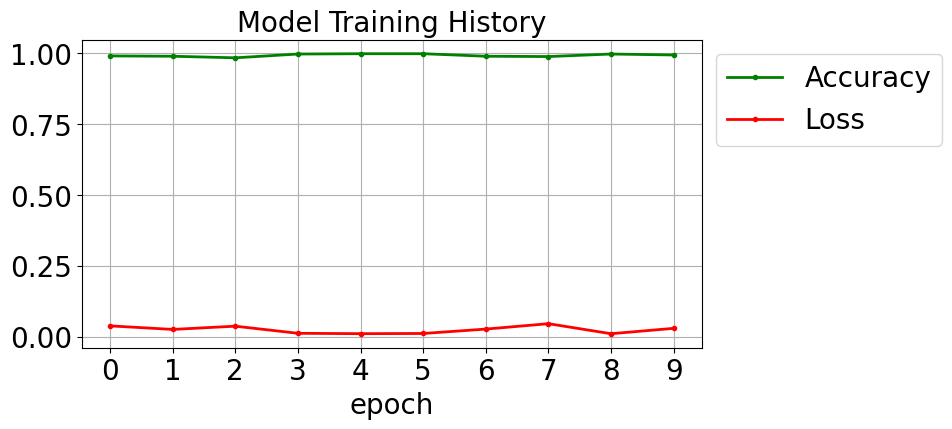

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/11 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  9%|▉         | 1/11 [00:00<00:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 2/11 [00:01<00:05,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 3/11 [00:01<00:04,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▋      | 4/11 [00:02<00:03,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 5/11 [00:02<00:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 6/11 [00:03<00:02,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▎   | 7/11 [00:03<00:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 8/11 [00:04<00:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 9/11 [00:04<00:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 10/11 [00:05<00:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|██████████| 11/11 [00:05<00:00,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


12it [00:06,  1.78it/s]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.94      0.96      0.95       304
    Melanoma       0.81      0.76      0.79        75

    accuracy                           0.92       379
   macro avg       0.88      0.86      0.87       379
weighted avg       0.92      0.92      0.92       379



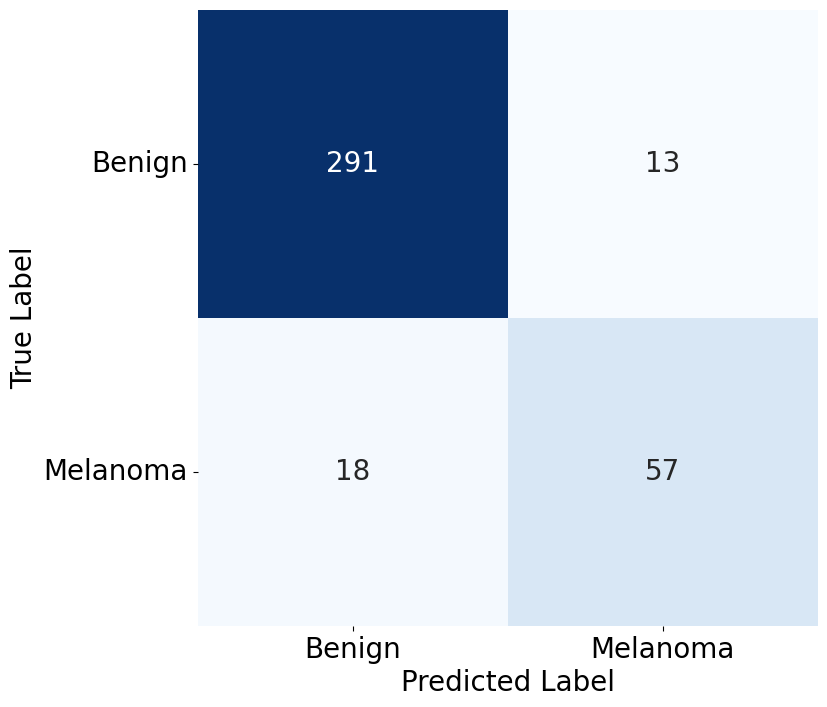

In [ ]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


TP: 57.000000 TN: 291.000000 FP: 13.000000 FN: 18.000000
acc: 0.91821
Specificity: 0.95724
 Recall: 0.76000
 Precision: 0.81429
F1 Score: 0.78621
